This file implements Monte-Carlo Conditional Flow Matching (MC-CFM) for a continuous gridworld environment.

In [1]:
# Conditional Flow Matching for Gridworld Successor Model

# %%
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
import torch.optim as optim

In [2]:
# Reproducibility
seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)


In [3]:
# -----------------------------
# Environment
# -----------------------------
class ContinuousGrid2D:
    def __init__(self, 
                 bounds=((0.0, 1.0), (0.0, 1.0)),
                 start=(0.05, 0.05),
                 goal=(0.95, 0.95),
                 dt=0.05,
                 goal_radius=0.03,
                 a_max=1.0,
                 max_steps=500):
        self.xmin, self.xmax = bounds[0]
        self.ymin, self.ymax = bounds[1]
        self.start = np.array(start, dtype=np.float32)
        self.goal = np.array(goal, dtype=np.float32)
        self.dt = float(dt)
        self.goal_radius = float(goal_radius)
        self.a_max = float(a_max)
        self.max_steps = int(max_steps)
        self.reset()

    def reset(self):
        self.state = self.start.copy()
        self.steps = 0
        return self.state.copy()

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        # clip action norm
        norm = np.linalg.norm(action)
        if norm > self.a_max:
            action = (action / (norm + 1e-8)) * self.a_max
        # integrate
        next_state = self.state + self.dt * action
        # clamp to bounds
        next_state[0] = np.clip(next_state[0], self.xmin, self.xmax)
        next_state[1] = np.clip(next_state[1], self.ymin, self.ymax)
        self.state = next_state
        self.steps += 1
        # termination
        dist = np.linalg.norm(self.state - self.goal)
        done = (dist <= self.goal_radius) or (self.steps >= self.max_steps)
        # reward: negative distance until absorption, then 0
        reward = 0.0 if dist <= self.goal_radius else -dist
        info = {"dist_to_goal": dist}
        return self.state.copy(), float(reward), done, info

# -----------------------------
# Stochastic Goal-Seeking Policy
# -----------------------------
class StochasticProportionalPolicy:
    def __init__(self, k=2.0, noise_std=0.1, a_max=1.0):
        self.k = float(k)
        self.noise_std = float(noise_std)
        self.a_max = float(a_max)

    def act(self, state, goal):
        state = np.asarray(state, dtype=np.float32)
        goal = np.asarray(goal, dtype=np.float32)
        direction = goal - state
        action = self.k * direction
        norm = np.linalg.norm(action)
        if norm > self.a_max:
            action = (action / (norm + 1e-8)) * self.a_max
        action = action + np.random.normal(0.0, self.noise_std, size=2).astype(np.float32)
        norm = np.linalg.norm(action)
        if norm > self.a_max:
            action = (action / (norm + 1e-8)) * self.a_max
        return action.astype(np.float32)

# %%
env = ContinuousGrid2D(dt=0.1)
policy = StochasticProportionalPolicy(k=3.0, noise_std=.01, a_max=1.0)


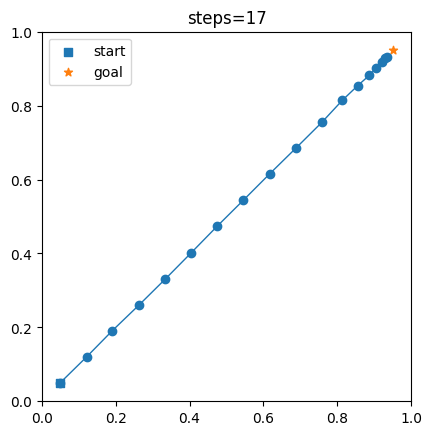

In [4]:
# Quick roll + viz
states = [env.reset()]
for _ in range(env.max_steps):
    a = policy.act(states[-1], env.goal)
    s, r, done, _ = env.step(a)
    states.append(s)
    if done: break
states = np.array(states, dtype=np.float32)
plt.figure()
plt.plot(states[:,0], states[:,1], marker='o', linewidth=1)
plt.scatter([env.start[0]],[env.start[1]], marker='s', label='start')
plt.scatter([env.goal[0]],[env.goal[1]], marker='*', label='goal')
plt.gca().set_aspect('equal', 'box')
plt.xlim(env.xmin, env.xmax); plt.ylim(env.ymin, env.ymax)
plt.title(f"steps={len(states)-1}")
plt.legend(); plt.show()

In [5]:
# -----------------------------
# Offline dataset
# -----------------------------
num_transitions_to_sample = 10000
dataset = []
while len(dataset) < num_transitions_to_sample:
    s = env.reset()
    for _ in range(env.max_steps):
        a = policy.act(s, env.goal)
        s2, r, done, _ = env.step(a)
        dataset.append(dict(state=s.copy(), action=a.copy(), reward=r, next_state=s2.copy(), done=done))
        s = s2
        if done: break

state_dim = dataset[0]["state"].shape[0]
action_dim = dataset[0]["action"].shape[0]
print("Dataset size:", len(dataset), "state_dim:", state_dim, "action_dim:", action_dim)


Dataset size: 10011 state_dim: 2 action_dim: 2


In [6]:
# # Flow Model for Successor States. We have based this flow model on the pytorch implementation of flow matching on the moons dataset.

# %%
class Flow(nn.Module):
    """
    Flow model to predict successor states.
    Input: [t, state, action, x_t]
    Output: velocity vector
    """
    def __init__(self, state_dim: int = 2, action_dim: int = 2, h: int = 64):
        super().__init__()
        # Input: t (1) + state (state_dim) + action (action_dim) + x_t (state_dim)
        input_dim = 1 + state_dim + action_dim + state_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, state_dim))
    
    def forward(self, t: Tensor, c: Tensor, x_t: Tensor) -> Tensor:
        """
        t: time [batch_size, 1]
        c: condition (state, action) [batch_size, state_dim + action_dim]
        x_t: current position [batch_size, state_dim]
        """
        return self.net(torch.cat((t, c, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor, c: Tensor) -> Tensor:
        """Euler integration step"""
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, c=c, x_t=x_t + self(c=c, x_t=x_t, t=t_start) * (t_end - t_start) / 2)


Illustration of a geometric distribution.

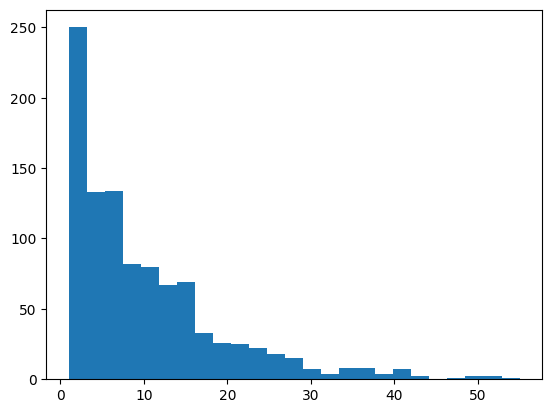

In [7]:
geom_samples = np.random.geometric(.1, size=1000)
plt.hist(geom_samples, bins=25)
plt.show()

# %%

In [8]:
def mc_sample(env, state, action, gamma):
    t = np.random.geometric(1-gamma) # Sample the timestep where the successor state is sampled from
    
    # Now act until t steps starting from state, action
    env.reset()
    env.state = state
    for t_ in range(t):
        if t_ == 0:
            next_state, reward, done, _ = env.step(action)
        else:
            next_state, reward, done, _ = env.step(policy.act(next_state, env.goal))
        if done:
            break
        state = next_state
    return state


Iteration 500/5000, loss 0.236032
Iteration 1000/5000, loss 0.151462
Iteration 1500/5000, loss 0.117138
Iteration 2000/5000, loss 0.114457
Iteration 2500/5000, loss 0.140178
Iteration 3000/5000, loss 0.159385
Iteration 3500/5000, loss 0.132185
Iteration 4000/5000, loss 0.111991
Iteration 4500/5000, loss 0.121968
Iteration 5000/5000, loss 0.080318


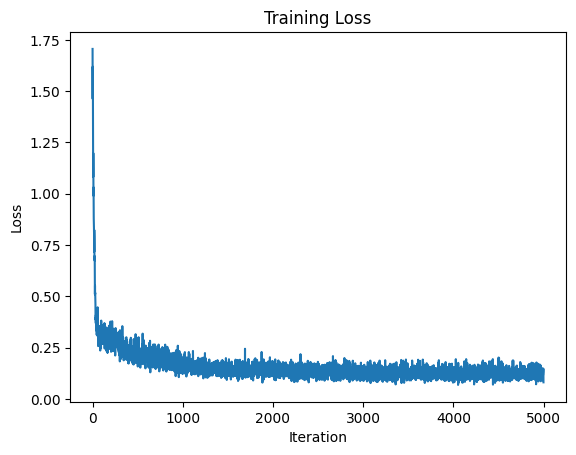

In [9]:
# # Training

# %%
flow = Flow(state_dim=state_dim, action_dim=action_dim, h=64)

optimizer = torch.optim.Adam(flow.parameters(), 1e-3)
loss_fn = nn.MSELoss()

losses = []
num_iters = 5000
batch_size = 256
gamma = 0.9

for it in range(num_iters):
    # Sample batch from dataset
    idx = np.random.choice(len(dataset), size=batch_size, replace=True)
    
    # x_1: successor states (target) retrieved from the environment
    x_1 = torch.tensor(np.stack([mc_sample(env, dataset[i]["state"], dataset[i]["action"], gamma) for i in idx]), dtype=torch.float32)
    # c: condition (state, action)
    states = torch.tensor(np.stack([dataset[i]["state"] for i in idx]), dtype=torch.float32)
    actions = torch.tensor(np.stack([dataset[i]["action"] for i in idx]), dtype=torch.float32)
    c = torch.cat([states, actions], dim=-1)
    
    # x_0: noise
    x_0 = torch.randn_like(x_1)
    
    # t: random time
    t = torch.rand(batch_size, 1)
    
    # Interpolate
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss = loss_fn(flow(t=t, x_t=x_t, c=c), dx_t)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if (it + 1) % 500 == 0:
        print(f"Iteration {it + 1}/{num_iters}, loss {loss.item():.6f}")

plt.figure()
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


In [10]:
n_sa = 10  # Number of starting states and actions
n_samples = 100  # Number of random initial points per (s, a) pair
n_steps = 100  # Number of integration steps

all_results = []

for i in range(n_sa):
    # Sample a starting state and action
    state = env.reset()
    action = policy.act(state, env.goal)
    
    # Create 10 random initial points (noise)
    x_t = torch.randn(size=(n_samples, state_dim))
    
    # Create condition: repeat state and action for all 10 samples
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).expand(n_samples, -1)
    action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).expand(n_samples, -1)
    c = torch.cat([state_tensor, action_tensor], dim=-1)
    
    # Integrate from t=0 to t=1
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    
    with torch.no_grad():
        for j in range(n_steps):
            x_t = flow.step(x_t=x_t,
                           t_start=time_steps[j],
                           t_end=time_steps[j + 1],
                           c=c)
    
    # Store results
    all_results.append({
        'state': state,
        'action': action,
        'successor_samples': x_t.numpy()
    })
    
print(f"Generated {n_sa} state-action pairs, each with {n_samples} successor samples")
print(f"Example result shape: {all_results[0]['successor_samples'].shape}")
# %%


Generated 10 state-action pairs, each with 100 successor samples
Example result shape: (100, 2)


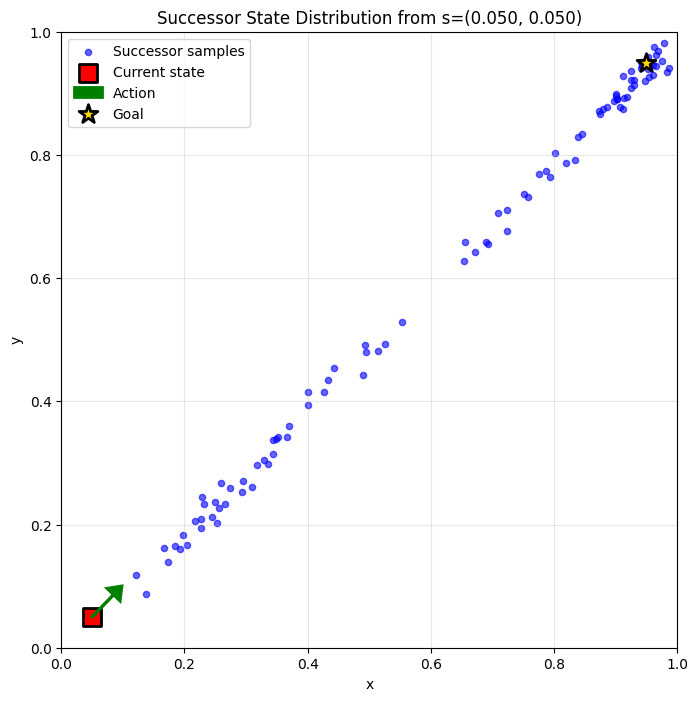

In [11]:
# Plot the successor samples for first state-action pair
result = all_results[0]
state = result['state']
action = result['action']
successor_samples = result['successor_samples']

# Clamp samples to environment bounds
successor_samples[:, 0] = np.clip(successor_samples[:, 0], env.xmin, env.xmax)
successor_samples[:, 1] = np.clip(successor_samples[:, 1], env.ymin, env.ymax)

plt.figure(figsize=(8, 8))
plt.scatter(successor_samples[:, 0], successor_samples[:, 1], s=20, alpha=0.6, c='blue', label='Successor samples')
plt.scatter([state[0]], [state[1]], s=150, c='red', marker='s', label='Current state', edgecolors='black', linewidths=2)
plt.arrow(state[0], state[1], action[0]*0.05, action[1]*0.05, 
          head_width=0.03, head_length=0.02, fc='green', ec='green', linewidth=2, label='Action')
plt.scatter([env.goal[0]], [env.goal[1]], s=200, c='gold', marker='*', label='Goal', edgecolors='black', linewidths=2)
plt.xlim(env.xmin, env.xmax)
plt.ylim(env.ymin, env.ymax)
plt.gca().set_aspect('equal', 'box')
plt.title(f'Successor State Distribution from s=({state[0]:.3f}, {state[1]:.3f})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()